In [155]:
import galsim
import batsim.stamp as batstamp
import batsim.transforms as batforms
import batsim._gsinterface as _gsi

import numpy as np
import numpy.lib.recfunctions as rfn
import matplotlib.pyplot as plt
import fpfs
from time import time

from tqdm import tqdm, trange

In [156]:
# load in COSMOS catalog
cosmos_cat = galsim.COSMOSCatalog()

# create a galaxy
rng = galsim.BaseDeviate(500)
randind = cosmos_cat.selectRandomIndex(rng=rng)
rec = cosmos_cat.getParametricRecord(index=randind)

print(ft)
gsparams = galsim.GSParams(maximum_fft_size=10000)
gal = cosmos_cat.makeGalaxy(index=randind, gal_type='parametric', gsparams=gsparams)

# get simulation pixel scale and number
sim_scale = gal.nyquist_scale
sim_nn = gal.getGoodImageSize(sim_scale)
print("Sim scale: ", sim_scale)
print("Sim nn: ", sim_nn)

0.001
Sim scale:  0.10848530957307764
Sim nn:  52


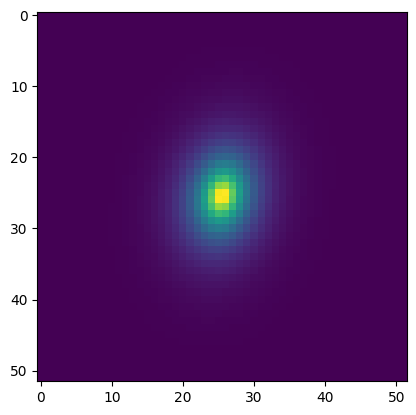

In [154]:
plt.imshow(gal.drawImage(nx=sim_nn, ny=sim_nn, scale=sim_scale).array)

In [158]:
# rotate and cancel shape noise
nrot = 4
rotated_gals = []
for i in range(nrot):
    rot_ang = np.pi / nrot * i
    ang = rot_ang * galsim.radians
    gal = gal.rotate(ang)
    rotated_gals.append(gal)

In [157]:
# This is my attempt to create an LSST-like PSF
# LSST Specifications
diameter = 8.4  # meters
effective_diameter = 6.423  # meters, area weighted
seeing = 0.67  # arcseconds

TotPSF = galsim.Moffat(beta=3.5, fwhm=seeing, flux=1.0, trunc=0.0001)
psf_arr = TotPSF.shift(0.5*measure_scale, 0.5*measure_scale).drawImage(nx=rcut*2, ny=rcut*2, scale=measure_scale).array

# Attempt measurement and detection with FPFS
measure_scale = 0.2
measure_nn = 128
rcut = measure_nn // 4
print("rcut: ", rcut)

# TODO: Rather than sample 4 times, sample once and rotate the resulting image
stamp = batstamp.Stamp(nn=measure_nn, scale=measure_scale, centering='fpfs')
align = batforms.IaTransform(hlr=hlr, A=0.04, beta=0, phi=np.radians(0), scale=sim_scale)
stamp.set_transform(align)

g1, g2 = align.get_g1g2(0,0)
kappa = 0.

galsim_arrs = []
batsim_arrs = []
for obj in tqdm(rotated_gals):
    # shear using galsim
    mu = 1/((1-kappa)**2 - g1**2 - g2**2)
    gs_shear = obj.shear(g1=g1, g2=g2)
    gs_conv = galsim.Convolve([gs_shear, TotPSF])
    gs_img = gs_conv.shift(0.5*measure_scale, 0.5*measure_scale).drawImage(nx=measure_nn, ny=measure_nn, scale=measure_scale)
    galsim_arrs.append(gs_img.array)

    # shear using batsim
    batsim_arrs.append(stamp.sample_convolution(obj, TotPSF))

rcut:  32


100%|██████████| 4/4 [00:00<00:00, 160.84it/s]


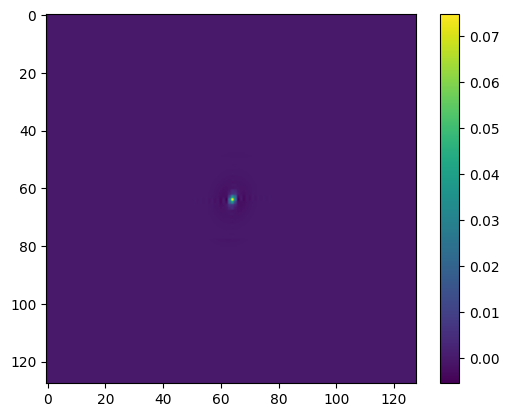

In [160]:
plt.imshow((batsim_arrs[0]-galsim_arrs[0]))
plt.colorbar()

In [162]:
def test_kernel_size(sigma_arcsec, psf_arr, gal_arr_list, scale, rcut):

    # initialize FPFS shear measurement task
    fpTask = fpfs.image.measure_source(psf_arr, sigma_arcsec=sigma_arcsec, pix_scale=scale)

    p1 = measure_nn //2 - rcut
    p2 = measure_nn //2 - rcut
    psf_arr_pad = np.pad(psf_arr, ((p1, p1), (p2, p2)))

    all_mms = []
    for gal_arr in gal_arr_list:
        coords = fpTask.detect_sources(gal_arr,psf_arr_pad,thres=0.01,thres2=-0.00,)
        # measure shear with FPFS on individual galaxies
        mms = fpTask.measure(gal_arr, coords)
        mms = fpTask.get_results(mms)
        all_mms.append(mms)
    combined_mms = rfn.stack_arrays(all_mms, usemask=False, asrecarray=True)

    # convert momemnts to ellipticity estimates
    ells = fpfs.catalog.fpfs_m2e(combined_mms, const=2000)
    resp = np.average(ells['fpfs_R1E'])
    shear = np.average(ells['fpfs_e1'])/resp
    shear_err = np.std(ells["fpfs_e1"]) / np.abs(resp) / np.sqrt(len(gal_arr_list))
    m_bias = abs(shear - g1)/g1

    return shear, shear_err, m_bias

In [165]:
# smaller kernel
kernel1 = 0.5

# measure on galsim galaxies
shear, shear_err, m_bias = test_kernel_size(sigma_arcsec=kernel1, psf_arr=psf_arr, gal_arr_list=galsim_arrs, scale=measure_scale, rcut=rcut)
print("Galsim shear: ", shear)
print("Galsim shear error: ", shear_err)
print("Galsim shear bias: %1.4e"%m_bias)

print("------------------------------------------")

# measure on batsim galaxies
shear, shear_err, m_bias = test_kernel_size(sigma_arcsec=kernel1, psf_arr=psf_arr, gal_arr_list=batsim_arrs, scale=measure_scale, rcut=rcut)
print("Batsim shear: ", shear)
print("Batsim shear error: ", shear_err)
print("Batsim shear bias: %1.4e"%m_bias)

Galsim shear:  0.019606699787880707
Galsim shear error:  0.05708318166483252
Galsim shear bias: 2.0057e-02
------------------------------------------
Batsim shear:  0.02002652061528528
Batsim shear error:  0.05827888714115025
Batsim shear bias: 9.2534e-04


In [159]:
# larger kernel
kernel2 = 0.7

# measure on galsim galaxies
shear, shear_err, m_bias = test_kernel_size(sigma_arcsec=kernel2, psf_arr=psf_arr, gal_arr_list=galsim_arrs, scale=measure_scale, rcut=rcut)
print("Galsim shear: ", shear)
print("Galsim shear error: ", shear_err)
print("Galsim shear bias: %1.4e"%m_bias)
    
print("------------------------------------------")

# measure on batsim galaxies
shear, shear_err, m_bias = test_kernel_size(sigma_arcsec=kernel2, psf_arr=psf_arr, gal_arr_list=batsim_arrs, scale=measure_scale, rcut=rcut)
print("Batsim shear: ", shear)
print("Batsim shear error: ", shear_err)
print("Batsim shear bias: %1.4e"%m_bias)

Galsim shear:  0.019694268980878928
Galsim shear error:  0.057228218405902774
Galsim shear bias: 1.5681e-02
------------------------------------------
Batsim shear:  0.02002441763264245
Batsim shear error:  0.05817184458681844
Batsim shear bias: 8.2023e-04


In [161]:
# Test different kernels
kernels = np.linspace(0.3,1.2,20)

galsim_bias = np.empty(len(kernels))
batsim_bias = np.empty(len(kernels))

for i in trange(len(kernels)):
    # measure on galsim galaxies
    _, _, m_bias = test_kernel_size(sigma_arcsec=kernels[i], psf_arr=psf_arr, gal_arr_list=galsim_arrs, scale=measure_scale, rcut=rcut)
    galsim_bias[i] = m_bias

    # measure on batsim galaxies
    _, _, m_bias = test_kernel_size(sigma_arcsec=kernels[i], psf_arr=psf_arr, gal_arr_list=batsim_arrs, scale=measure_scale, rcut=rcut)
    batsim_bias[i] = m_bias

100%|██████████| 20/20 [00:21<00:00,  1.08s/it]


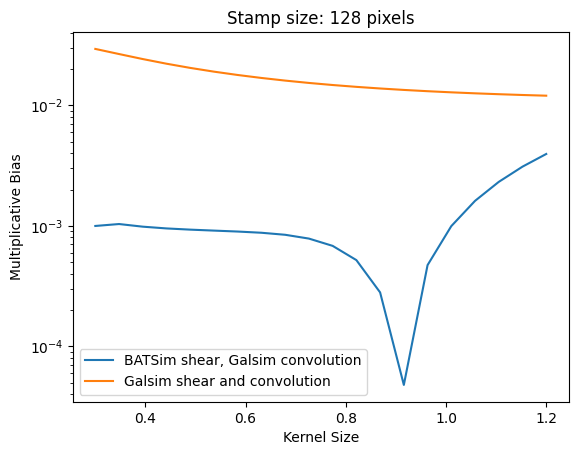

In [163]:
plt.plot(kernels, abs(batsim_bias), label='BATSim shear, Galsim convolution')
plt.plot(kernels, abs(galsim_bias), label='Galsim shear and convolution')
plt.legend()
plt.xlabel('Kernel Size')
plt.ylabel('Multiplicative Bias')
plt.yscale('log')
plt.title('Stamp size: %d pixels'%measure_nn)
plt.savefig('kernel_size_bias-stamp%d.png'%measure_nn, dpi=300)

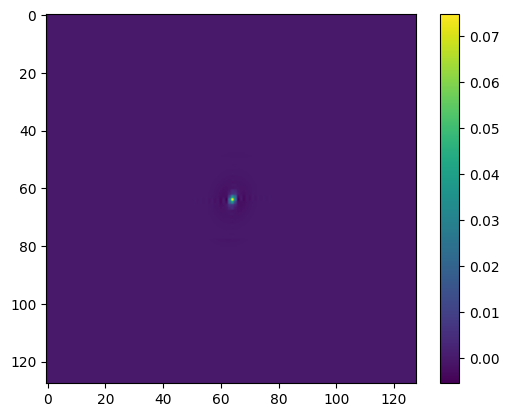

In [166]:
plt.imshow(batsim_arrs[0] - galsim_arrs[0])
plt.colorbar()

In [164]:
print(galsim_arrs[0].sum(), batsim_arrs[0].sum())

29.217598 29.217600778903513
